# Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../data/features.csv') as f1:
    df = pd.read_csv(f1)

with open('../data/outcomes.csv') as f2:
    outcomes = pd.read_csv(f2, usecols=['student_id', 'outcome'])
                           
df = pd.merge(df, outcomes, on='student_id')
 

df.drop(['Unnamed: 0', 'course_id'], axis='columns', inplace=True)
labels = ['fail', 'pass']
target_variable_name = 'outcome'
df.dropna(axis='index', how='any', subset=['outcome'], inplace=True)
df.outcome = df.outcome.astype(int)

In [3]:
df.head()

,student_id,tot_page_views,average_daily_views,median_daily_views,max_daily_views,days_with_views,hours_with_views,max_views_per_hour,avg_views_per_hour,median_views_per_hour,avg_hours_with_views_per_day,max_hours_with_views_per_day,median_hours_with_views_per_day,tot_participations,average_daily_participations,median_daily_participations,max_daily_participations,days_with_participations,outcome
0,47649,1153,22.607843,16.0,118.0,51,71,88.0,16.239437,15.0,1.392157,1.392157,1.0,23,0.460000,0.0,4.0,50,True
1,52263,744,15.183673,0.0,93.0,49,67,48.0,11.104478,8.0,1.367347,1.367347,0.0,20,0.434783,0.0,3.0,46,True
2,24036,341,6.686275,0.0,80.0,51,27,48.0,12.629630,11.0,0.529412,0.529412,0.0,15,0.333333,0.0,3.0,45,True
3,52137,237,5.042553,0.0,68.0,47,19,32.0,12.473684,9.0,0.404255,0.404255,0.0,6,0.187500,0.0,3.0,32,True
4,52267,665,13.300000,0.0,161.0,50,42,118.0,15.833333,8.0,0.840000,0.840000,0.0,26,0.520000,0.0,5.0,50,True


## Missing Values

Since there are only a few missing values we can simply discard them

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   student_id                       425 non-null    int64  
 1   tot_page_views                   425 non-null    int64  
 2   average_daily_views              422 non-null    float64
 3   median_daily_views               422 non-null    float64
 4   max_daily_views                  422 non-null    float64
 5   days_with_views                  425 non-null    int64  
 6   hours_with_views                 425 non-null    int64  
 7   max_views_per_hour               422 non-null    float64
 8   avg_views_per_hour               422 non-null    float64
 9   median_views_per_hour            422 non-null    float64
 10  avg_hours_with_views_per_day     422 non-null    float64
 11  max_hours_with_views_per_day     422 non-null    float64
 12  median_hours_with_view

In [5]:
df.dropna(axis='index', how='any', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416 entries, 0 to 424
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   student_id                       416 non-null    int64  
 1   tot_page_views                   416 non-null    int64  
 2   average_daily_views              416 non-null    float64
 3   median_daily_views               416 non-null    float64
 4   max_daily_views                  416 non-null    float64
 5   days_with_views                  416 non-null    int64  
 6   hours_with_views                 416 non-null    int64  
 7   max_views_per_hour               416 non-null    float64
 8   avg_views_per_hour               416 non-null    float64
 9   median_views_per_hour            416 non-null    float64
 10  avg_hours_with_views_per_day     416 non-null    float64
 11  max_hours_with_views_per_day     416 non-null    float64
 12  median_hours_with_view

## Feature Selection


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [8]:
x = df.drop(['student_id','outcome'], axis='columns')
y = df['outcome'].values.reshape(-1,1)

In [9]:
x.shape, y.shape

((416, 17), (416, 1))

In [10]:
Min_Max = MinMaxScaler()
X = Min_Max.fit_transform(x)
Y= Min_Max.fit_transform(y)
# Split the data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((291, 17), (125, 17))

In [11]:
scores_df = pd.DataFrame()
# Create a naive random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train,np.ravel(Y_train), cv=10)

print("Naive Random Forest all features")
print(f"Mean Accuracy: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Accuracy: 0.8213793103448277 
Standard Deviation : 0.052653715852762434


In [12]:
scores_df = scores_df.append({'# features':'all',
               'Mean Accuracy':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)

In [13]:
scores_df

,# features,Mean Accuracy,Std
0,all,0.821379,0.052654


### Lasso

In [14]:
sel = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel.fit(X_train, np.ravel(Y_train))

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [15]:
print("Selected features :")
_ = [print(f"- {c}") for c in x.loc[:, sel.get_support()].columns]

Selected features :
- hours_with_views
- avg_views_per_hour
- tot_participations
- days_with_participations


In [16]:
X_train_df = pd.DataFrame(X_train)
selected_features = X_train_df.columns[(sel.get_support())]
print(f'total features: {(X_train_df.shape[1])}')
print(f'selected features: {len(selected_features)}')
print(f'features with coefficients shrank to zero: {np.sum(sel.estimator_.coef_ == 0)}')

total features: 17
selected features: 4
features with coefficients shrank to zero: 13


In [17]:
removed_features = X_train_df.columns[(sel.estimator_.coef_ == 0).ravel().tolist()]
removed_features

Int64Index([0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15], dtype='int64')

In [18]:
X_train_lasso_selected = sel.transform(X_train_df)
X_test_lasso_selected = sel.transform(X_test)

In [19]:
# Create a naive random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train_lasso_selected, np.ravel(Y_train), cv=10)

print("Naive Random Forest all features")
print(f"Mean Accuracy: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Accuracy: 0.8317241379310346 
Standard Deviation : 0.06587560792419064


In [20]:
scores_df = scores_df.append({'# features':'lasso',
               'Mean Accuracy':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)
scores_df.head()

,# features,Mean Accuracy,Std
0,all,0.821379,0.052654
1,lasso,0.831724,0.065876


### RFE

In [21]:
#clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, np.ravel(Y_train))

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                       random_state=0),
      scoring='accuracy')

In [22]:
print(f'Optimal number of features: {rfecv.n_features_}')

Optimal number of features: 8


In [23]:
print("Selected features :")
_ = [print(f"- {c}") for c in x.loc[:, rfecv.support_].columns]

Selected features :
- tot_page_views
- days_with_views
- hours_with_views
- avg_views_per_hour
- avg_hours_with_views_per_day
- tot_participations
- average_daily_participations
- days_with_participations


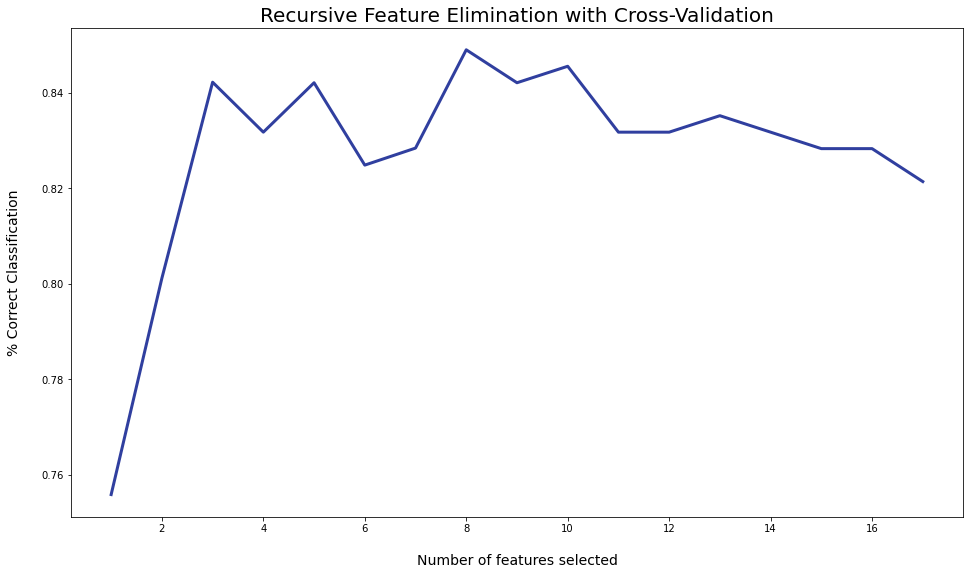

In [24]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [25]:
X_train_rfe_selected = rfecv.transform(X_train_df)
X_test_rfe_selected = rfecv.transform(X_test)

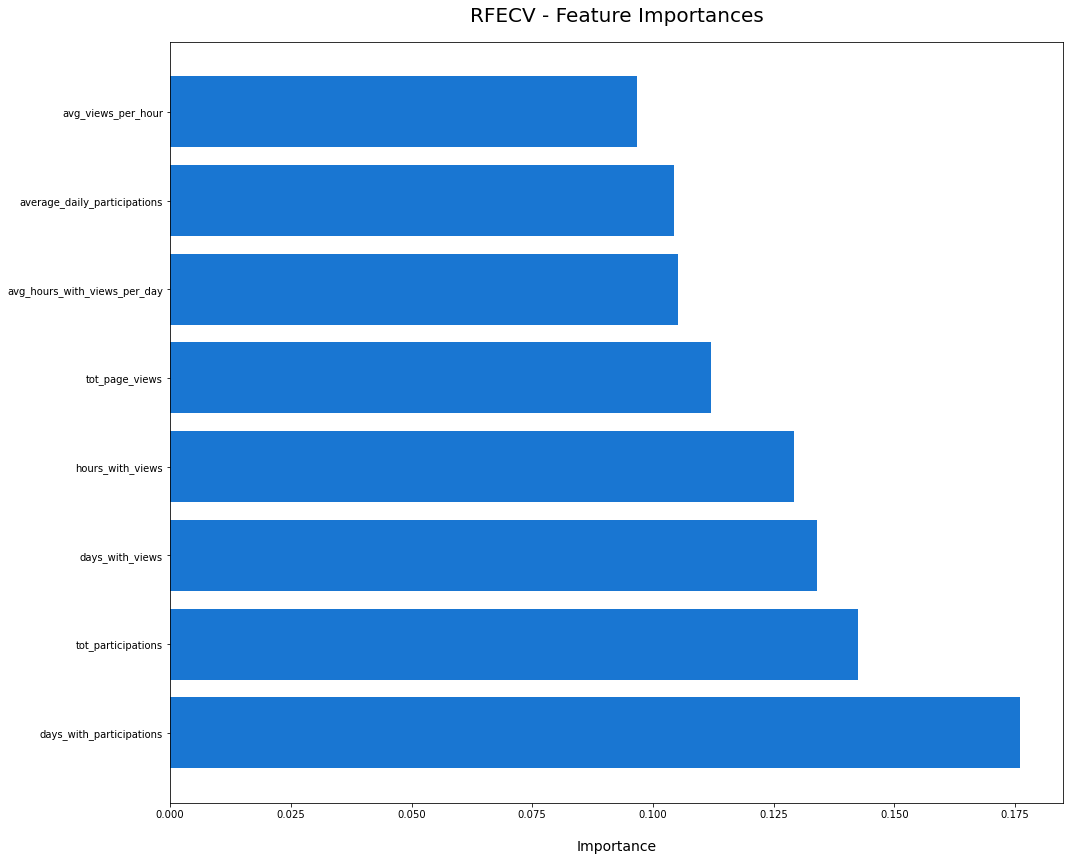

In [26]:
dset = pd.DataFrame()
dset['attr'] = x.loc[:, rfecv.support_].columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [27]:
# Create a naive random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train_rfe_selected, np.ravel(Y_train), cv=10)

print("Naive Random Forest all features")
print(f"Mean Accuracy: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Accuracy: 0.8420689655172413 
Standard Deviation : 0.07222965092845275


In [28]:
scores_df = scores_df.append({'# features':'rfe',
               'Mean Accuracy':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)
scores_df.head()

,# features,Mean Accuracy,Std
0,all,0.821379,0.052654
1,lasso,0.831724,0.065876
2,rfe,0.842069,0.072230


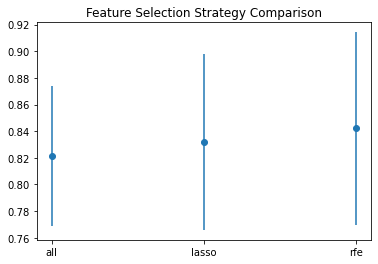

In [29]:
plt.errorbar(scores_df['# features'], scores_df['Mean Accuracy'], yerr=scores_df['Std'], fmt="o")
plt.title('Feature Selection Strategy Comparison')
plt.show()

## Model

## GridSearch CV: XGB and RF compared

In [30]:
import xgboost as xgb 

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
#The data is stored in a DMatrix object 
#label is used to define our outcome variable
dtrain=xgb.DMatrix(x_train,label=y_train)
dtest=xgb.DMatrix(x_test)

In [ ]:
x.loc[:, rfecv.support_]#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [ ]:
#training our model 
num_round=50
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

In [ ]:
#Execution time of the model 
execution_time_xgb = stop-start 
execution_time_xgb

In [ ]:
#datetime.timedelta( , , ) representation => (days , seconds , microseconds) 
#now predicting our model on test set 
ypred=xg.predict(dtest) 
ypred

In [ ]:
#Converting probabilities into 1 or 0  
for i in range(0,9769): 
    if ypred[i]>=.5:       # setting threshold to .5 
       ypred[i]=1 
    else: 
       ypred[i]=0  

In [ ]:
#calculating accuracy of our model 
from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_test,ypred) 
accuracy_xgb


In [ ]:
# fine tune XGB and RF

In [ ]:
#look at confusion matrix
# minimize erros on failure
# 70% errors basically data imblance... so maybe balance data?